# Bot Tweets

(at long last)

Import our libraries needed for the data handling.

In [3]:
import pandas as pd
import numpy as np
import json
import glob

In [4]:
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)
# and widen the output
# pd.set_option('display.width', 1200)

Libraries for stupid text encoding

In [5]:
from urllib2 import quote
# Unicode strings
from __future__ import unicode_literals

Import libraries needed for visualization.

In [6]:
import matplotlib
import matplotlib.pyplot as plt
# Within notebook viewing
%matplotlib inline

print (matplotlib.__version__)

1.5.3


In [7]:
# Import for axes, color, etc
from pylab import *

Natural Language Processing

In [8]:
%run twokenize.py
import nltk

### Directories

In [9]:
testDir = '../../data/external/trump-bots/'
botDir = '../../data/external/botresults/'
outDir = '../../data/processed/bot-tweets/'

Read in the data files by combining the extracted files.

In [10]:
# Crudely combine
process = []
for f in glob.glob((botDir + "*.txt")):
    with open(f, "rb") as infile:
        for line in infile:
            process.append(json.loads(line))
raw = pd.DataFrame.from_records(process)

del process

print (raw.shape)

(77722, 33)


##### Helper functions

In [11]:
def tknz(text):
    tokens = tokenizeRawTweetText(text)
    filt = [x for x in tokens if not (x.startswith('RT') 
                                   or x.startswith('@') or x.startswith(':') 
                                   or x.startswith('http://') or x.startswith('https://') 
                                  or x.startswith('-') or x.startswith('and') 
                                    or x.startswith('.') or x.startswith(',') 
                                     or x.startswith("'") or x == ('' or '"'))]
    return filt

def hsh(tokens):
    # reads a list of tokens
    # tuped = tuple(tokens)
    tuped = ', '.join(tokens)
    hashed = hash(tuped)
    return hashed

In [12]:
def extractInfo(tweet):
    # User variables
    userID = tweet['user']['id_str']
    screenName = tweet['user']['screen_name']
    # Tweet Variables
    text = tweet['text']
    tokens = tknz(text)
    hashed = hsh(tokens)
    retweet = 1 if (tweet['retweet'] == True) else 0
    
    timestamp = tweet['timestamp_ms']
    
    return {'userID':userID, 'screenName':screenName, 'timestamp':timestamp, \
            'text':text, 'tokens':tokens, 'hash':hashed, 'retweet':retweet}
    
    #### below is a horrible rendition of network variables
    
"""
# RT, reply, quoting, or none?
    try:
        if (tweet['retweeted_status'] == True):
            method = 'retweet'
            otherID = tweet['retweeted_status']['user']['id_str']

        if (type(tweet['in_reply_to_user_id_str']) != np.float64):
            method = 'replyUser'
            otherID = tweet['in_reply_to_user_id_str']
        elif (tweet['in_reply_to_status_id_str']):
            method = 'replyStatus'
            otherID = None
        else:
            method = None
            otherID = None

        return {'userID':userID, 'screenName':screenName, 'text':text, 'timestamp':timestamp,
                'method':method, 'otherID':otherID}
    except:
        print tweet
"""

u"\n# RT, reply, quoting, or none?\n    try:\n        if (tweet['retweeted_status'] == True):\n            method = 'retweet'\n            otherID = tweet['retweeted_status']['user']['id_str']\n\n        if (type(tweet['in_reply_to_user_id_str']) != np.float64):\n            method = 'replyUser'\n            otherID = tweet['in_reply_to_user_id_str']\n        elif (tweet['in_reply_to_status_id_str']):\n            method = 'replyStatus'\n            otherID = None\n        else:\n            method = None\n            otherID = None\n\n        return {'userID':userID, 'screenName':screenName, 'text':text, 'timestamp':timestamp,\n                'method':method, 'otherID':otherID}\n    except:\n        print tweet\n"

In [13]:
extracted = pd.DataFrame.from_records(raw.apply(lambda x: extractInfo(x), axis=1))
extracted['timestamp'] = pd.to_datetime(extracted['timestamp'], unit='ms')
extracted['token_str'] = extracted['tokens'].apply(lambda x: ', '.join(x))

extracted.head()

,hash,screenName,text,timestamp,tokens,userID,token_str
0,8401775961062800512,Scrufey21,RT @robinleeclark: Hillary is a murderer and a...,2015-07-06 00:12:43.046,"[Hillary, is, a, murderer, a, traitor, that's,...",490179072,"Hillary, is, a, murderer, a, traitor, that's, ..."
1,-7017692310915600254,Scrufey21,RT @PatriotMash: Clinton uses two aides and a ...,2015-07-06 00:17:23.293,"[Clinton, uses, two, aides, a, rope, to, lasso...",490179072,"Clinton, uses, two, aides, a, rope, to, lasso,..."
2,4819910249842125834,Scrufey21,RT @NoahWehrman: Press prepare for another day...,2015-07-06 00:19:58.259,"[Press, prepare, for, another, day, of, coveri...",490179072,"Press, prepare, for, another, day, of, coverin..."
3,8041086589735528761,CyberAnonymous,nytimes: Hillary Clinton reassures gay youth i...,2015-07-06 00:20:15.542,"[nytimes, Hillary, Clinton, reassures, gay, yo...",128334973,"nytimes, Hillary, Clinton, reassures, gay, you..."
4,-4371809372265221000,Scrufey21,RT @LessGovMoreFun: Truth be told: https://t....,2015-07-06 00:20:17.984,"[Truth, be, told]",490179072,"Truth, be, told"


In [14]:
hashes = extracted[['screenName', 'text', 'tokens', 'hash']].set_index('hash')
hashes.head()

,screenName,text,tokens
hash,,,
8401775961062800512,Scrufey21,RT @robinleeclark: Hillary is a murderer and a...,"[Hillary, is, a, murderer, a, traitor, that's,..."
-7017692310915600254,Scrufey21,RT @PatriotMash: Clinton uses two aides and a ...,"[Clinton, uses, two, aides, a, rope, to, lasso..."
4819910249842125834,Scrufey21,RT @NoahWehrman: Press prepare for another day...,"[Press, prepare, for, another, day, of, coveri..."
8041086589735528761,CyberAnonymous,nytimes: Hillary Clinton reassures gay youth i...,"[nytimes, Hillary, Clinton, reassures, gay, yo..."
-4371809372265221000,Scrufey21,RT @LessGovMoreFun: Truth be told: https://t....,"[Truth, be, told]"


In [22]:
# Get most popular 
print ('Most popular tweet hashes.')

popularTweets = extracted['hash'].value_counts()
popularTweets.columns = ['frequency']

popularTweets.head(10)

Most popular tweet hashes.


-535364539560055252     1574
-1290198111922655402    1362
 1650226427655343970     807
-5630792624845697664     624
 0                       609
-4102906781732687656     520
 5602520607808939820     484
 3167448423410501280     176
 8100076757054270788     146
-7094954994022569809     142
Name: hash, dtype: int64

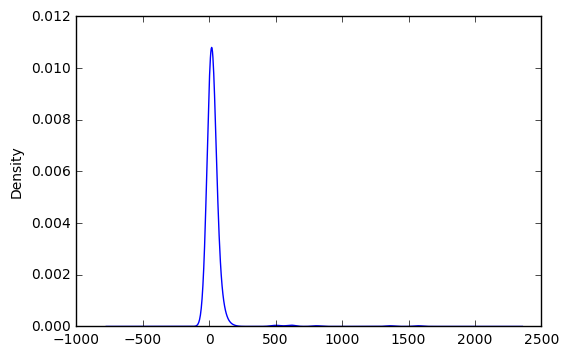

In [46]:
#popularTweets[popularTweets > 1].head(500).plot(kind='bar', xlim=[0, 500], alpha=0.5)
popularTweets[popularTweets > 1].head(500).plot(kind='kde', x=[1,])

In [47]:
mostDiverseTweets = extracted[['userID', 'hash', 'text']].groupby('hash')\
    .agg({'userID': pd.Series.nunique})\
    .sort_values(by='userID', ascending=False)
mostDiverseTweets.columns = ['uniq_users']
   
print ('Tweets with multiple (unique) users.\n{} statuses with duplicate users'.format(mostDiverseTweets.size))
mostDiverseTweets.head()

Tweets with multiple (unique) users.


,uniq_users
hash,
-2964838977105228756,50
8100076757054270788,50
-4993197743230146561,48
5748713145738005256,47
7719283613370225873,19


In [57]:
# users
mostProlificUsers = extracted['userID'].value_counts()
mostProlificUsers.head()

3532804813            17062
3920277023             8337
724050768106500096     7697
15195038               4962
490179072              3330
Name: userID, dtype: int64

In [54]:
tweets = extracted[extracted['retweet'] == 0]
retweets = extracted[extracted['retweet'] == 1]

KeyError: u'retweet'

In [ ]:
totalObserved = extracted.size
tweetsObserved = tweets.size
retweetsObserved = retweets.size

uniqueObserved = extracted['token_str'].unique().size
dupedObserved = totalObserved - uniqueObserved
print ('number of statuses observed: {}\nnumber of *unique* statuses: {}\n...meaning {} tweets/retweets were duplicates sent to people'\
       .format(tweetsObserved, uniqueObserved, dupedObserved))

print ('# tweets: {}\n# retweets: {}'.format(tweetsObserved, retweetsObserved))

In [ ]:
#popularTweets['token_str'] = .loc[]

In [61]:
mostProlificUsers.head()

3532804813            17062
3920277023             8337
724050768106500096     7697
15195038               4962
490179072              3330
Name: userID, dtype: int64

In [ ]:
extracted['token_str'].value_counts().head()

In [ ]:
# use the value counts to get the hash
hashes['tokens'].head(20).unique()

In [ ]:
# alternatively merge in pandas